In [133]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import KFold

from sklearn.preprocessing import StandardScaler

from scipy import stats

%matplotlib inline

In [609]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [610]:
test_id = test_data.Id

In [611]:
train_data = train_data.drop(['Id'] , axis = 1)

test_data = test_data.drop(['Id'] , axis = 1)

In [612]:
numerical_columns = train_data.dtypes[train_data.dtypes != object].index #含有预测值 SalePrice
categorical_columns = train_data.dtypes[train_data.dtypes == object].index

In [587]:
#下面的eda全是numerical features

In [613]:
missing_columns_num = (train_data[numerical_columns].isnull().sum()[train_data[numerical_columns].isnull().sum().values>0]).index
#含有缺失值得numerical columns

In [614]:
missing_columns_num#含有确实值得numerical的columns 缺失值处理

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [ ]:
#===============
#===============
#===============
#对这些numerical缺失值 先不处理 因为下面的图显示 这些feature与saleprice相关性也不强

In [615]:
train_data.LotFrontage.fillna(train_data.GarageYrBlt).corr(train_data.SalePrice)

0.026326630004173915

In [616]:
corr_matrix = train_data.corr() #数字型feature的皮尔逊相关系数

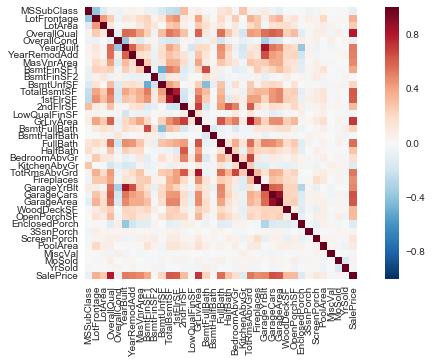

In [617]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix  , square=True)

In [618]:
largest_10_corr_matrix = corr_matrix.nlargest(10 , 'SalePrice')
largest_10_corr_matrix_index = largest_10_corr_matrix.index #largest corr
largest = train_data[largest_10_corr_matrix_index].corr()

largest_10_corr_matrix_index = list(set(largest_10_corr_matrix_index)-set(['GarageArea' , '1stFlrSF'])) #已经存在与其相关的的feature 去掉

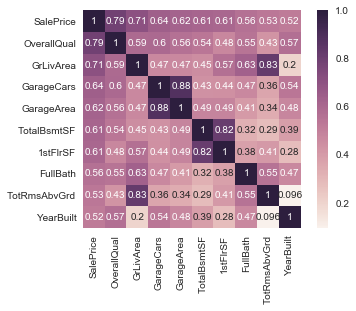

In [597]:
sns.heatmap(largest , square=True , annot=True)

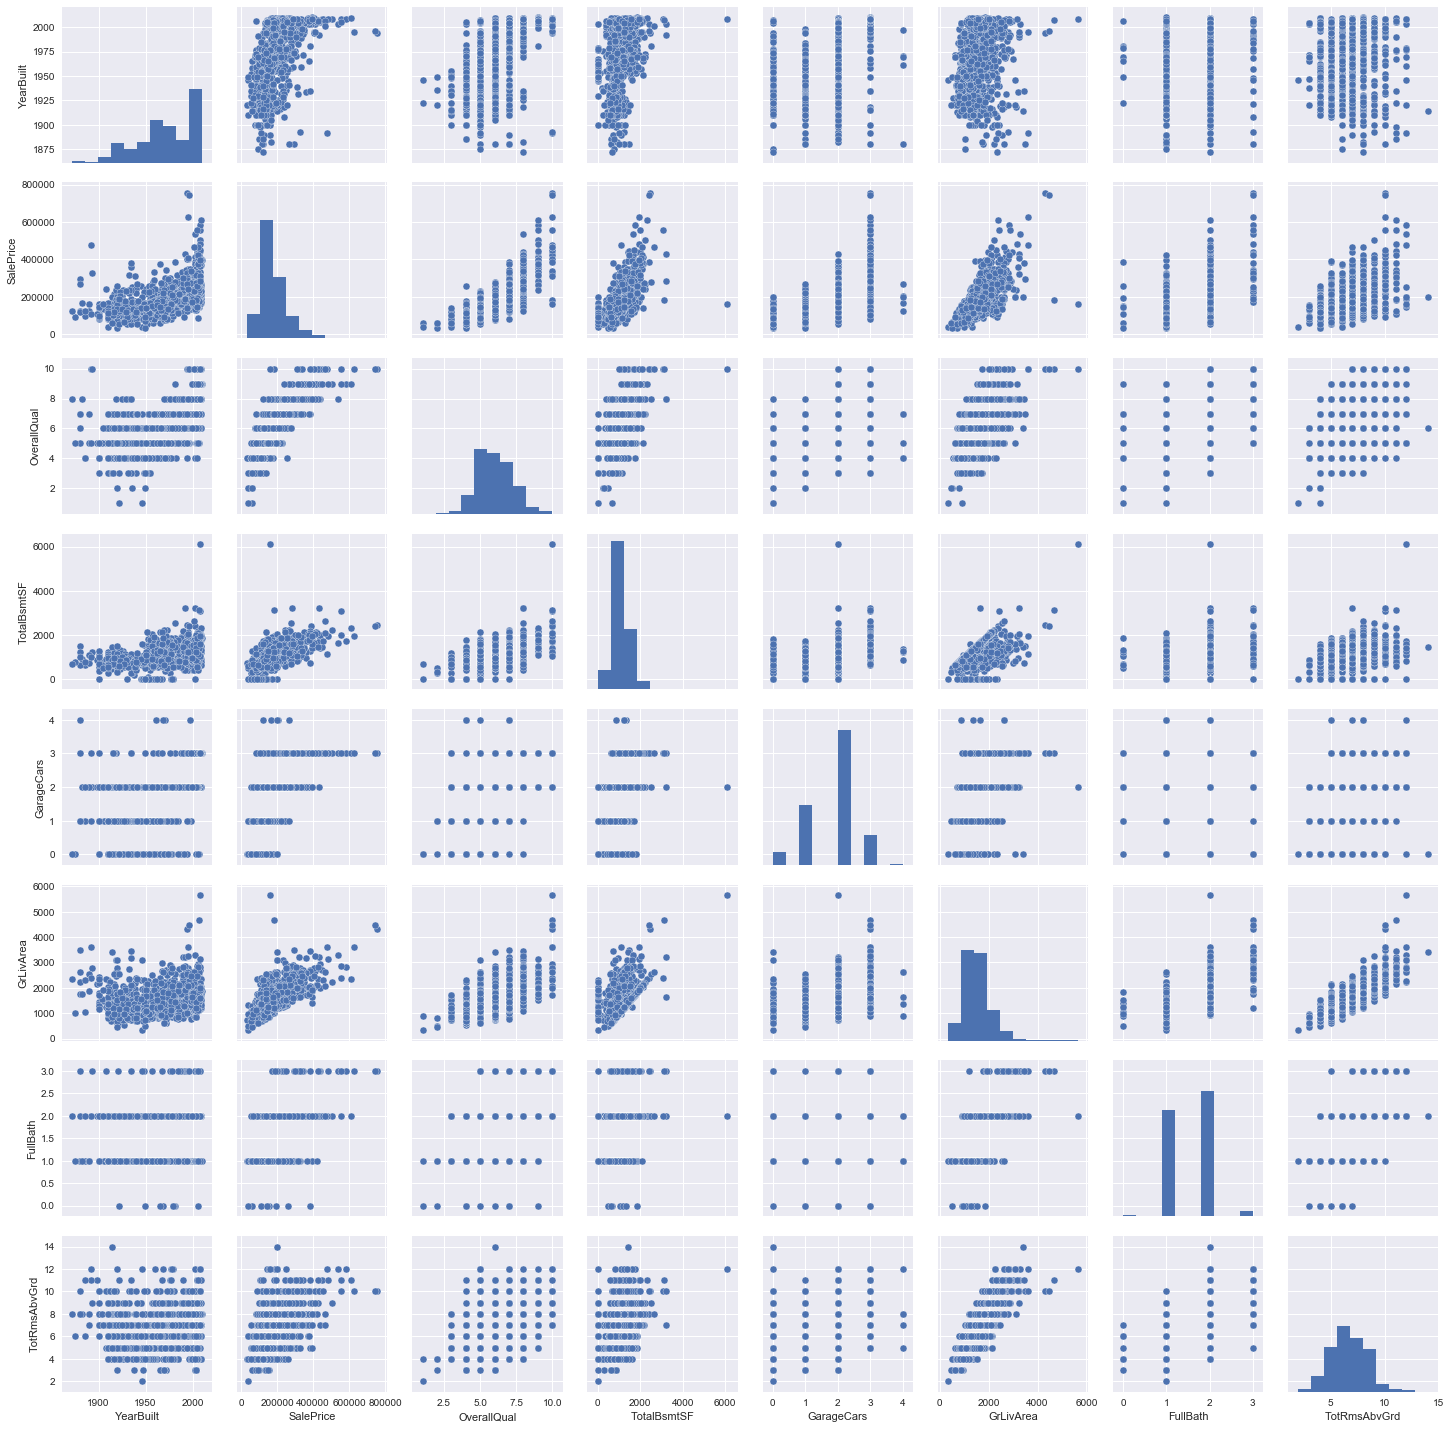

In [23]:
#plt.scatter(train_data.GrLivArea , train_data.SalePrice)
sns.pairplot(train_data[largest_10_corr_matrix_index])

In [ ]:
#==========
#==========
#==========
#下面是处理numerical的离群值

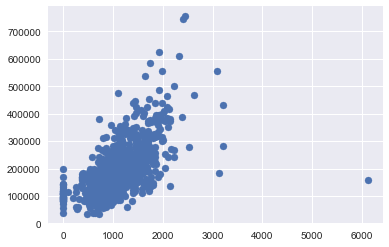

In [619]:
plt.scatter(train_data.TotalBsmtSF , train_data.SalePrice)

In [620]:
train_data.loc[train_data.TotalBsmtSF>6000].index #根据上图找离群值
train_data = train_data.drop(1298) #删除离群值

In [621]:
train_data.TotalBsmtSF.corr(train_data.SalePrice)

0.6457492001588273

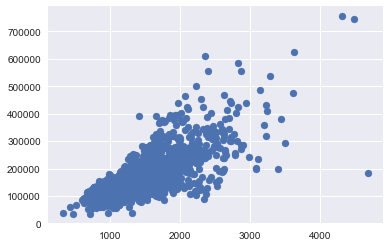

In [622]:
plt.scatter(train_data.GrLivArea , train_data.SalePrice)

In [623]:
train_data.loc[train_data.GrLivArea>4500,'GrLivArea'].index #找离群点
train_data = train_data.drop([523]) #上面已经把1298删除了
#注意删除前面的离群值后 后面的样本序号会变

In [624]:
train_data.GrLivArea.corr(train_data.SalePrice)

0.7349681645359328

In [625]:
#===============
#下面进行除偏
largest_10_corr_matrix_index

['YearBuilt',
 'SalePrice',
 'OverallQual',
 'TotalBsmtSF',
 'GarageCars',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd']

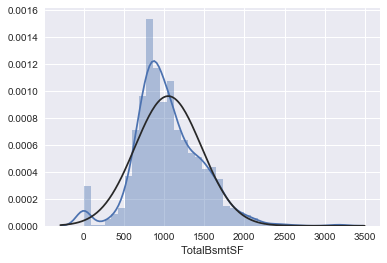

In [626]:
#对上面的相关性最大进行测试 发现3个进行除偏

sns.distplot(train_data.TotalBsmtSF , fit = stats.norm) #from scipy import stats
#fig = plt.figure()
#stats.probplot(train_data.TotalBsmtSF , plot=plt) #绘制和norm拟合的曲线图

In [627]:
#进行对数除偏
train_data.SalePrice = train_data.SalePrice.apply(np.log)
train_data.GrLivArea = train_data.GrLivArea.apply(np.log)



In [607]:
#因为存在0 log会出错 单独log
#但是相关性下降 暂时不进行log除偏
#==========
#==========
#暂时不除偏
train_data['extra'] = pd.Series(len(train_data.TotalBsmtSF) , index = train_data.index)
train_data.extra = 0
train_data.loc[train_data.TotalBsmtSF > 0 , 'extra'] = 1
train_data.loc[train_data.extra == 1 , 'TotalBsmtSF'] = np.log(train_data.TotalBsmtSF)

I:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [628]:
print(train_data.TotalBsmtSF.corr(train_data.SalePrice))
print(train_data.GrLivArea.corr(train_data.SalePrice))


0.647562694364615
0.7374273443470197


In [629]:
train_data.yearcat.corr(train_data.SalePrice)

AttributeError: 'DataFrame' object has no attribute 'yearcat'

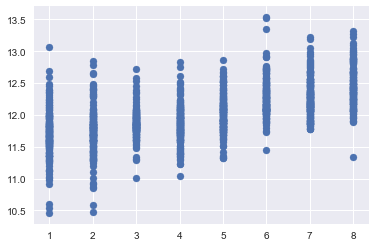

In [293]:
plt.scatter(train_data.yearcat , train_data.SalePrice)

In [630]:
#生成看一下
categorical_index_yearbuilt = pd.qcut(train_data.YearBuilt , 8).value_counts().sort_values(ascending = True)
categorical_index_yearbuilt.index

CategoricalIndex([  (2005.0, 2010.0],   (1954.0, 1963.0],   (1990.0, 2000.0],
                    (1963.0, 1972.5], (1871.999, 1929.0],   (1972.5, 1990.0],
                    (1929.0, 1954.0],   (2000.0, 2005.0]],
                 categories=[(1871.999, 1929.0], (1929.0, 1954.0], (1954.0, 1963.0], (1963.0, 1972.5], (1972.5, 1990.0], (1990.0, 2000.0], (2000.0, 2005.0], (2005.0, 2010.0]], ordered=True, dtype='category')

In [631]:
train_data['yearcat'] = pd.Series( 99 , index = train_data.YearBuilt.index)

In [632]:
#测试8分组
train_data.loc[ (train_data.YearBuilt>1871.999) & (train_data.YearBuilt<=1929.0)  , 'yearcat'] = 1
train_data.loc[ (train_data.YearBuilt>1929.0) & (train_data.YearBuilt<=1954.0)  , 'yearcat'] = 2
train_data.loc[ (train_data.YearBuilt>1954.0) & (train_data.YearBuilt<=1963.0)  , 'yearcat'] = 3
train_data.loc[ (train_data.YearBuilt>1963.0) & (train_data.YearBuilt<=1972.5)  , 'yearcat'] = 4
train_data.loc[ (train_data.YearBuilt>1972.5) & (train_data.YearBuilt<=1990.0)  , 'yearcat'] = 5
train_data.loc[ (train_data.YearBuilt>1990.0) & (train_data.YearBuilt<=2000.0)  , 'yearcat'] = 6
train_data.loc[ (train_data.YearBuilt>2000.0) & (train_data.YearBuilt<=2005.0)  , 'yearcat'] = 7
train_data.loc[ (train_data.YearBuilt>2005.0) & (train_data.YearBuilt<=2010.0)  , 'yearcat'] = 8


In [633]:
train_data[['yearcat' , 'SalePrice']].groupby('yearcat' ,as_index = False).mean()

,yearcat,SalePrice
0,1,11.714751
1,2,11.744722
2,3,11.868257
3,4,11.868666
4,5,12.031668
5,6,12.278816
6,7,12.281369
7,8,12.456687


In [634]:
train_data['save_year_built'] = train_data.YearBuilt.copy()
train_data.YearBuilt = train_data.yearcat.copy()

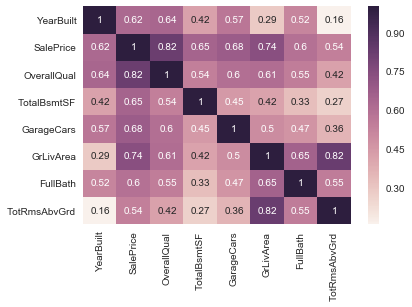

In [635]:
#调整后的特征后的相关性
sns.heatmap(train_data[largest_10_corr_matrix_index].corr() , annot=True)

In [636]:
#增加几个数字型试试
largest_13_corr_matrix_index = corr_matrix.nlargest(13 , 'SalePrice').index #多拿了3个高相关的特征

In [637]:
set(largest_13_corr_matrix_index)-set(largest_10_corr_matrix_index)
#maxvnrarea 这个就废除了 缺失值太多
#GarageYrBlt 也有缺失值

{'1stFlrSF', 'GarageArea', 'GarageYrBlt', 'MasVnrArea', 'YearRemodAdd'}

In [638]:
train_data.YearRemodAdd.corr(train_data.SalePrice)

0.5659921073141684

In [639]:
cate_yearremoadd = pd.qcut(train_data.YearRemodAdd , 8).value_counts().index
cate_yearremoadd

CategoricalIndex([  (1994.0, 2000.0],   (1977.0, 1994.0],   (1952.0, 1967.0],
                  (1949.999, 1952.0],   (2000.0, 2004.0],   (1967.0, 1977.0],
                    (2004.0, 2006.0],   (2006.0, 2010.0]],
                 categories=[(1949.999, 1952.0], (1952.0, 1967.0], (1967.0, 1977.0], (1977.0, 1994.0], (1994.0, 2000.0], (2000.0, 2004.0], (2004.0, 2006.0], (2006.0, 2010.0]], ordered=True, dtype='category')

In [640]:
train_data['yearremoadd'] = pd.Series(99 , index = train_data.YearRemodAdd.index)

In [641]:
train_data.loc[(train_data.YearRemodAdd>1949.999) & (train_data.YearRemodAdd<=1952.0) , 'yearremoadd'] = 1
train_data.loc[(train_data.YearRemodAdd>1952.0) & (train_data.YearRemodAdd<=1967.0) , 'yearremoadd'] = 2
train_data.loc[(train_data.YearRemodAdd>1967.0) & (train_data.YearRemodAdd<=1977.0) , 'yearremoadd'] = 3
train_data.loc[(train_data.YearRemodAdd>1977.0) & (train_data.YearRemodAdd<=1994.0) , 'yearremoadd'] = 4
train_data.loc[(train_data.YearRemodAdd>1994.0) & (train_data.YearRemodAdd<=2000.0) , 'yearremoadd'] = 5
train_data.loc[(train_data.YearRemodAdd>2000.0) & (train_data.YearRemodAdd<=2004.0) , 'yearremoadd'] = 6
train_data.loc[(train_data.YearRemodAdd>2004.0) & (train_data.YearRemodAdd<=2006.0) , 'yearremoadd'] = 7
train_data.loc[(train_data.YearRemodAdd>2006.0) & (train_data.YearRemodAdd<=2010.0) , 'yearremoadd'] = 8

In [642]:
train_data.yearremoadd.corr(train_data.SalePrice)

0.5508281255765975

In [643]:
train_data['save_year_remo'] = train_data.YearRemodAdd
train_data.YearRemodAdd = train_data.yearremoadd

In [644]:
#============
extra_numerical_columns = list(set(numerical_columns) - set(largest_10_corr_matrix_index))
extra_numerical_columns.append('SalePrice')
extra_corr_matrix = train_data[extra_numerical_columns].corr()

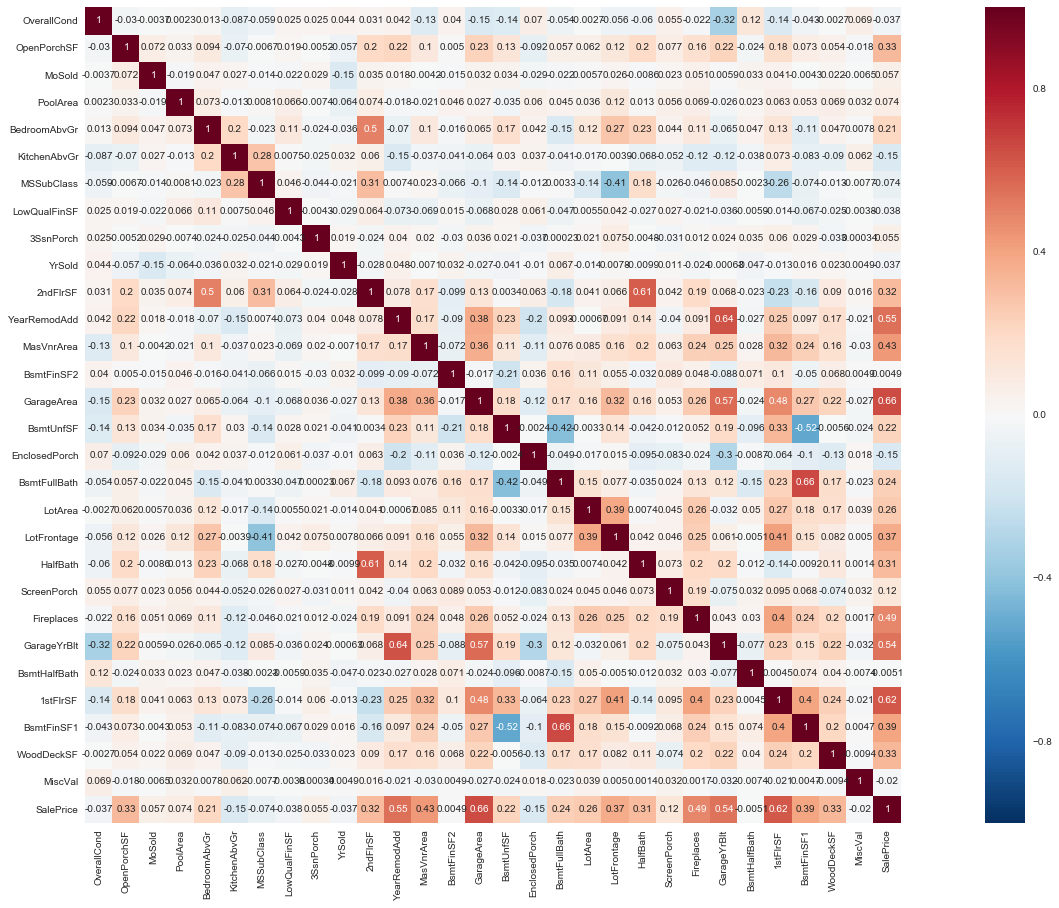

In [429]:
fig = plt.figure(figsize=(30 , 15))
sns.heatmap(extra_corr_matrix ,annot=True ,square=True)

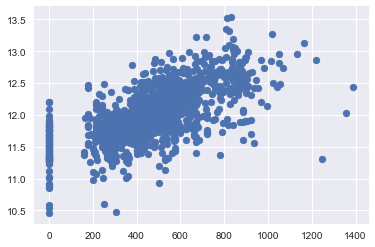

In [645]:
plt.scatter(train_data.GarageArea , train_data.SalePrice)

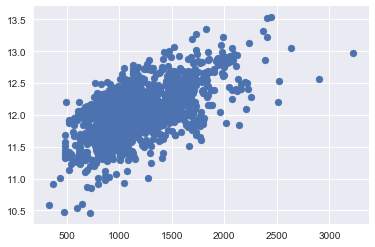

In [646]:
plt.scatter(train_data['1stFlrSF'] , train_data.SalePrice)

In [647]:
train_data.SalePrice.corr(train_data['1stFlrSF'])

0.6204997176278015

In [ ]:
#==============
#==============
#==============
#==============
#

In [648]:
#==================
#==================
#==================
#==================
#下面处理标称型特征
categorical_columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [649]:
missing_columns_cat = categorical_columns[train_data[categorical_columns].isnull().sum().values != 0]
missing_columns_cat

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

In [650]:
missing_columns_cat_most = ['Alley' , 'FireplaceQu' , 'PoolQC' , 'Fence' , 'MiscFeature'] #这几个可以直接删除
#fireplacequ对
#缺失值太多的features

In [651]:
missing_columns_cat_more = list(set(missing_columns_cat) - set(missing_columns_cat_most))

In [481]:
missing_columns_cat_more #缺失值不是太多的

['MasVnrType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtQual',
 'Electrical',
 'GarageType',
 'BsmtFinType2',
 'GarageQual',
 'GarageFinish',
 'GarageCond']

In [652]:
for i in missing_columns_cat_more:
    train_data[str('save_')+str(i)] = train_data[i]
#将变换前的数据保存起来

In [533]:
train_data[missing_columns_cat_more].isnull().sum()

MasVnrType       8
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtQual         0
Electrical       1
GarageType      81
BsmtFinType2    38
GarageQual      81
GarageFinish     0
GarageCond      81
dtype: int64

In [653]:
train_data.MasVnrType.fillna(2 , inplace=True)#.corr(train_data.SalePrice)
train_data.BsmtCond.fillna(1     ,inplace = True)#.corr(train_data.SalePrice)
train_data.BsmtExposure.fillna(1 ,inplace = True)#.corr(train_data.SalePrice)
train_data.BsmtFinType1.fillna(1 ,inplace = True)#.corr(train_data.SalePrice)
train_data.Electrical.fillna(2   ,inplace = True)#.corr(train_data.SalePrice)
train_data.GarageType.fillna(1   ,inplace = True)#.corr(train_data.SalePrice)
train_data.BsmtFinType2.fillna(1 ,inplace = True)#.corr(train_data.SalePrice)
train_data.GarageQual.fillna(1   ,inplace = True)#.corr(train_data.SalePrice)
train_data.GarageCond.fillna(1   ,inplace = True)#.corr(train_data.SalePrice)
#相关性较高的两个
train_data.BsmtQual = train_data.BsmtQual.fillna(1.0)
train_data.GarageFinish = train_data.GarageFinish.fillna(1.0)


In [654]:
#有缺失值的categorical 数字化
for i in missing_columns_cat_more:
    a=list(train_data[i].value_counts().index)
    b=len(a)
    c= [i+1 for i in range(b)]
    d=dict(zip(a,c))
    train_data[i] = train_data[i].map(d)

In [655]:
for i in missing_columns_cat_more:
    print(i , train_data[i].corr(train_data.SalePrice))

MasVnrType 0.38589374397997456
BsmtCond -0.23169589412539224
BsmtExposure 0.11422111400249725
BsmtFinType1 -0.24953416464527645
BsmtQual 0.2586141971290272
Electrical -0.2860613571380638
GarageType -0.3302919307945854
BsmtFinType2 -0.0975771579696364
GarageQual -0.22378444342618153
GarageFinish 0.261308630802642
GarageCond -0.27711611771920974


In [656]:
#没有缺失值的categorical features
no_missing_columns_cat = list(set(categorical_columns) - set(missing_columns_cat))
no_missing_columns_cat

['MSZoning',
 'SaleCondition',
 'KitchenQual',
 'Foundation',
 'HeatingQC',
 'HouseStyle',
 'Heating',
 'RoofStyle',
 'Street',
 'LandSlope',
 'Exterior1st',
 'ExterCond',
 'Condition2',
 'BldgType',
 'CentralAir',
 'Functional',
 'SaleType',
 'PavedDrive',
 'Condition1',
 'ExterQual',
 'RoofMatl',
 'LotConfig',
 'Neighborhood',
 'Utilities',
 'LandContour',
 'Exterior2nd',
 'LotShape']

In [657]:
#将没有缺失值的feature值 保存起来
for i in no_missing_columns_cat:
    train_data[str('save_')+str(i)] = train_data[i]

In [658]:
#没有缺失值的categorical数字化  上面是保存起来
for i in no_missing_columns_cat:
    a=list(train_data[i].value_counts().index)
    b=len(a)
    c= [i+1 for i in range(b)]
    d=dict(zip(a,c))
    train_data[i] = train_data[i].map(d)

In [659]:
for i in no_missing_columns_cat:
    print(i , train_data[i].corr(train_data.SalePrice))

MSZoning -0.23784563097849198
SaleCondition -0.04264714146506254
KitchenQual 0.41738072502507867
Foundation -0.49399114219364987
HeatingQC -0.4059607743751238
HouseStyle -0.08556750999542276
Heating -0.15270190911319234
RoofStyle 0.13143740926196715
Street -0.05736409651863653
LandSlope 0.03855224342216915
Exterior1st -0.2195793710721291
ExterCond -0.16804736760629332
Condition2 -0.003190638636373269
BldgType -0.18287932342837662
CentralAir -0.3515983055231601
Functional -0.13440820487344018
SaleType 0.0627819748214356
PavedDrive -0.2626868664632533
Condition1 -0.02302440615372432
ExterQual 0.5260345513018608
RoofMatl 0.0827845254286087
LotConfig 0.10575570793681478
Neighborhood 0.08864675118339427
Utilities -0.012629641448547831
LandContour 0.057795960587207554
Exterior2nd -0.19736146160777202
LotShape 0.28821188241184026


In [664]:
#救命 恢复回来
#下面进行哑变量处理
for i in missing_columns_cat_more:
    train_data[i] = train_data[str('save_')+str(i)]

for i in no_missing_columns_cat:
    train_data[i] = train_data[str('save_')+str(i)]

In [666]:
all_columns = train_data.columns #保存所有的columns

In [667]:
train_data = pd.get_dummies(train_data)

dummy_columns = set(train_data.columns) - set(all_columns)
#test_data = pd.get_dummies(test_data)

In [669]:
dummy_columns = list(dummy_columns)

In [ ]:
#==============
#==============

#==============
#测试区域

In [694]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

forest = RandomForestRegressor(n_estimators=100)
linear = LinearRegression()
svr = SVR()
dec_tree = DecisionTreeRegressor()
knn = KNeighborsRegressor()
ridge = Ridge(alpha=3)
lasso = Lasso()

classifier = {'random_forest':forest , 'LR':linear , 'SVM':svr , 'decison_tree':dec_tree , 'KNN':knn , 'ridge':ridge , 'lasso':lasso}
#kf = KFold(train_data.shape[0] , 10 , True)

In [674]:
def rmse(model , data , label):
    #cv=5 分为5folds
    #在这里会对模型进行训练 
    return np.sqrt(-cross_val_score(model, data, label, scoring="neg_mean_squared_error", cv = 10))

In [670]:
vali_index = largest_10_corr_matrix_index.copy()

In [671]:
vali_index.remove('SalePrice')

'''numerical features'''
#numerical features
vali_index.append('YearRemodAdd') #这个保留 能减小一点 rmse


#下面两个可以不考虑 已经和别的特征相关了
#vali_index.append('GarageArea')
#vali_index.append('1stFlrSF')
'''下面是categorical features'''

#categorical features 有缺失值的 已经填充 较高相关的
#vali_index.append('BsmtQual')
#vali_index.append('GarageFinish')

#categorical features 没有缺失值 较高相关的
#vali_index.append('KitchenQual')
#vali_index.append('ExterQual')

In [662]:
vali_index =vali_index + no_missing_columns_cat
vali_index = vali_index + missing_columns_cat_more

In [672]:
vali_index+=dummy_columns

In [573]:
#vali_index.remove('TotRmsAbvGrd') #暂时保留这个feature

In [693]:
best_model = _
smallest_rmse = 1.0
for model_name , model in classifier.items():
    result = np.average(rmse(model , train_data[vali_index] , train_data.SalePrice))
    if result<smallest_rmse:
        smallest_rmse = result
        best_model = model_name
        
    print(model_name , result)

print('\nbest:',best_model , smallest_rmse)
#真大

random_forest 0.1415029175631199
LR 0.1286338506524269
SVM 0.21785314046651566
decison_tree 0.19996154024821516
KNN 0.2472492939546521
ridge 0.12635477655157573
lasso 0.3046785201815814

best: ridge 0.12635477655157573


In [687]:
from sklearn.model_selection import GridSearchCV

def grid_search_scoring(model , data , label):
    return np.average(rmse(model , data , label))

In [688]:
param_grid={'alpha':[0.5 , 1.0 , 1.5 , 2.0 , 2.5 , 3.0]}
kfold = KFold(train_data.shape[0] , 10 , True)
grid = GridSearchCV(estimator=ridge , param_grid=param_grid , scoring=grid_search_scoring , cv=kfold)

In [689]:
grid.fit(train_data[vali_index] , train_data.SalePrice)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=1458, n_folds=10, shuffle=True, random_state=None),
       error_score='raise',
       estimator=Ridge(alpha=3, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function grid_search_scoring at 0x00000239A7E94158>,
       verbose=0)

In [691]:
grid.best_score_

0.189017025638297

In [ ]:
Ridge()

In [442]:
largest_10_corr_matrix_index

['YearBuilt',
 'OverallQual',
 'TotalBsmtSF',
 'GarageCars',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'SalePrice']

In [706]:
#================
#================
#投入使用
forest.fit(train_data[features] , train_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [500]:
#进行预测
#生成结果
result = forest.predict(test_data)
result = np.exp(result)
result_csv = pd.DataFrame({'Id':test_id , 'SalePrice':result})
result_csv.to_csv('submit2.csv' , index=False)